## Load and Clean Data

1. Both TE and gene data generated by UROMOL group is loaded into a pandas dataframe
2. Samples are ordered by there UROMOL ID ('U0001' -> 'U2122')
3. All simple repeat elements are eliminated
4. Elements with no expression in any sample were also removed

In [1]:
import pandas as pd
from Funcs.ReorderUROMOL import UROMOLreorder

# load in both Gene and TE transcriptomic expression
Gene = pd.read_csv('~/Desktop/UROMOL-TE/UROMOL-Gene.csv', index_col='Unnamed: 0')
TE = pd.read_csv('~/Desktop/UROMOL-TE/UROMOL-TE.csv', index_col='Unnamed: 0')

# order the dataframe by UROMOL ID
IDs = []
for sample in TE.columns.tolist():
    IDs.append(int(sample.split('U')[1]))

TE = UROMOLreorder(IDs, TE)
Gene = UROMOLreorder(IDs, Gene)

# eliminate all simple repeat elements from the TE dataset
nonTE = []
for element in TE.index.values.tolist():
    if '(' in element:
        nonTE.append(element)
TE = TE.drop(nonTE, axis='rows')

# remove all TE elements with no expression
TE = TE.loc[~(TE==0).all(axis=1)]

## Batch Effect Evaluation

1. Both clean TE and Gene datasets were zero centered and log2 transformed
2. Boxplot are generated for both normalized dataframes

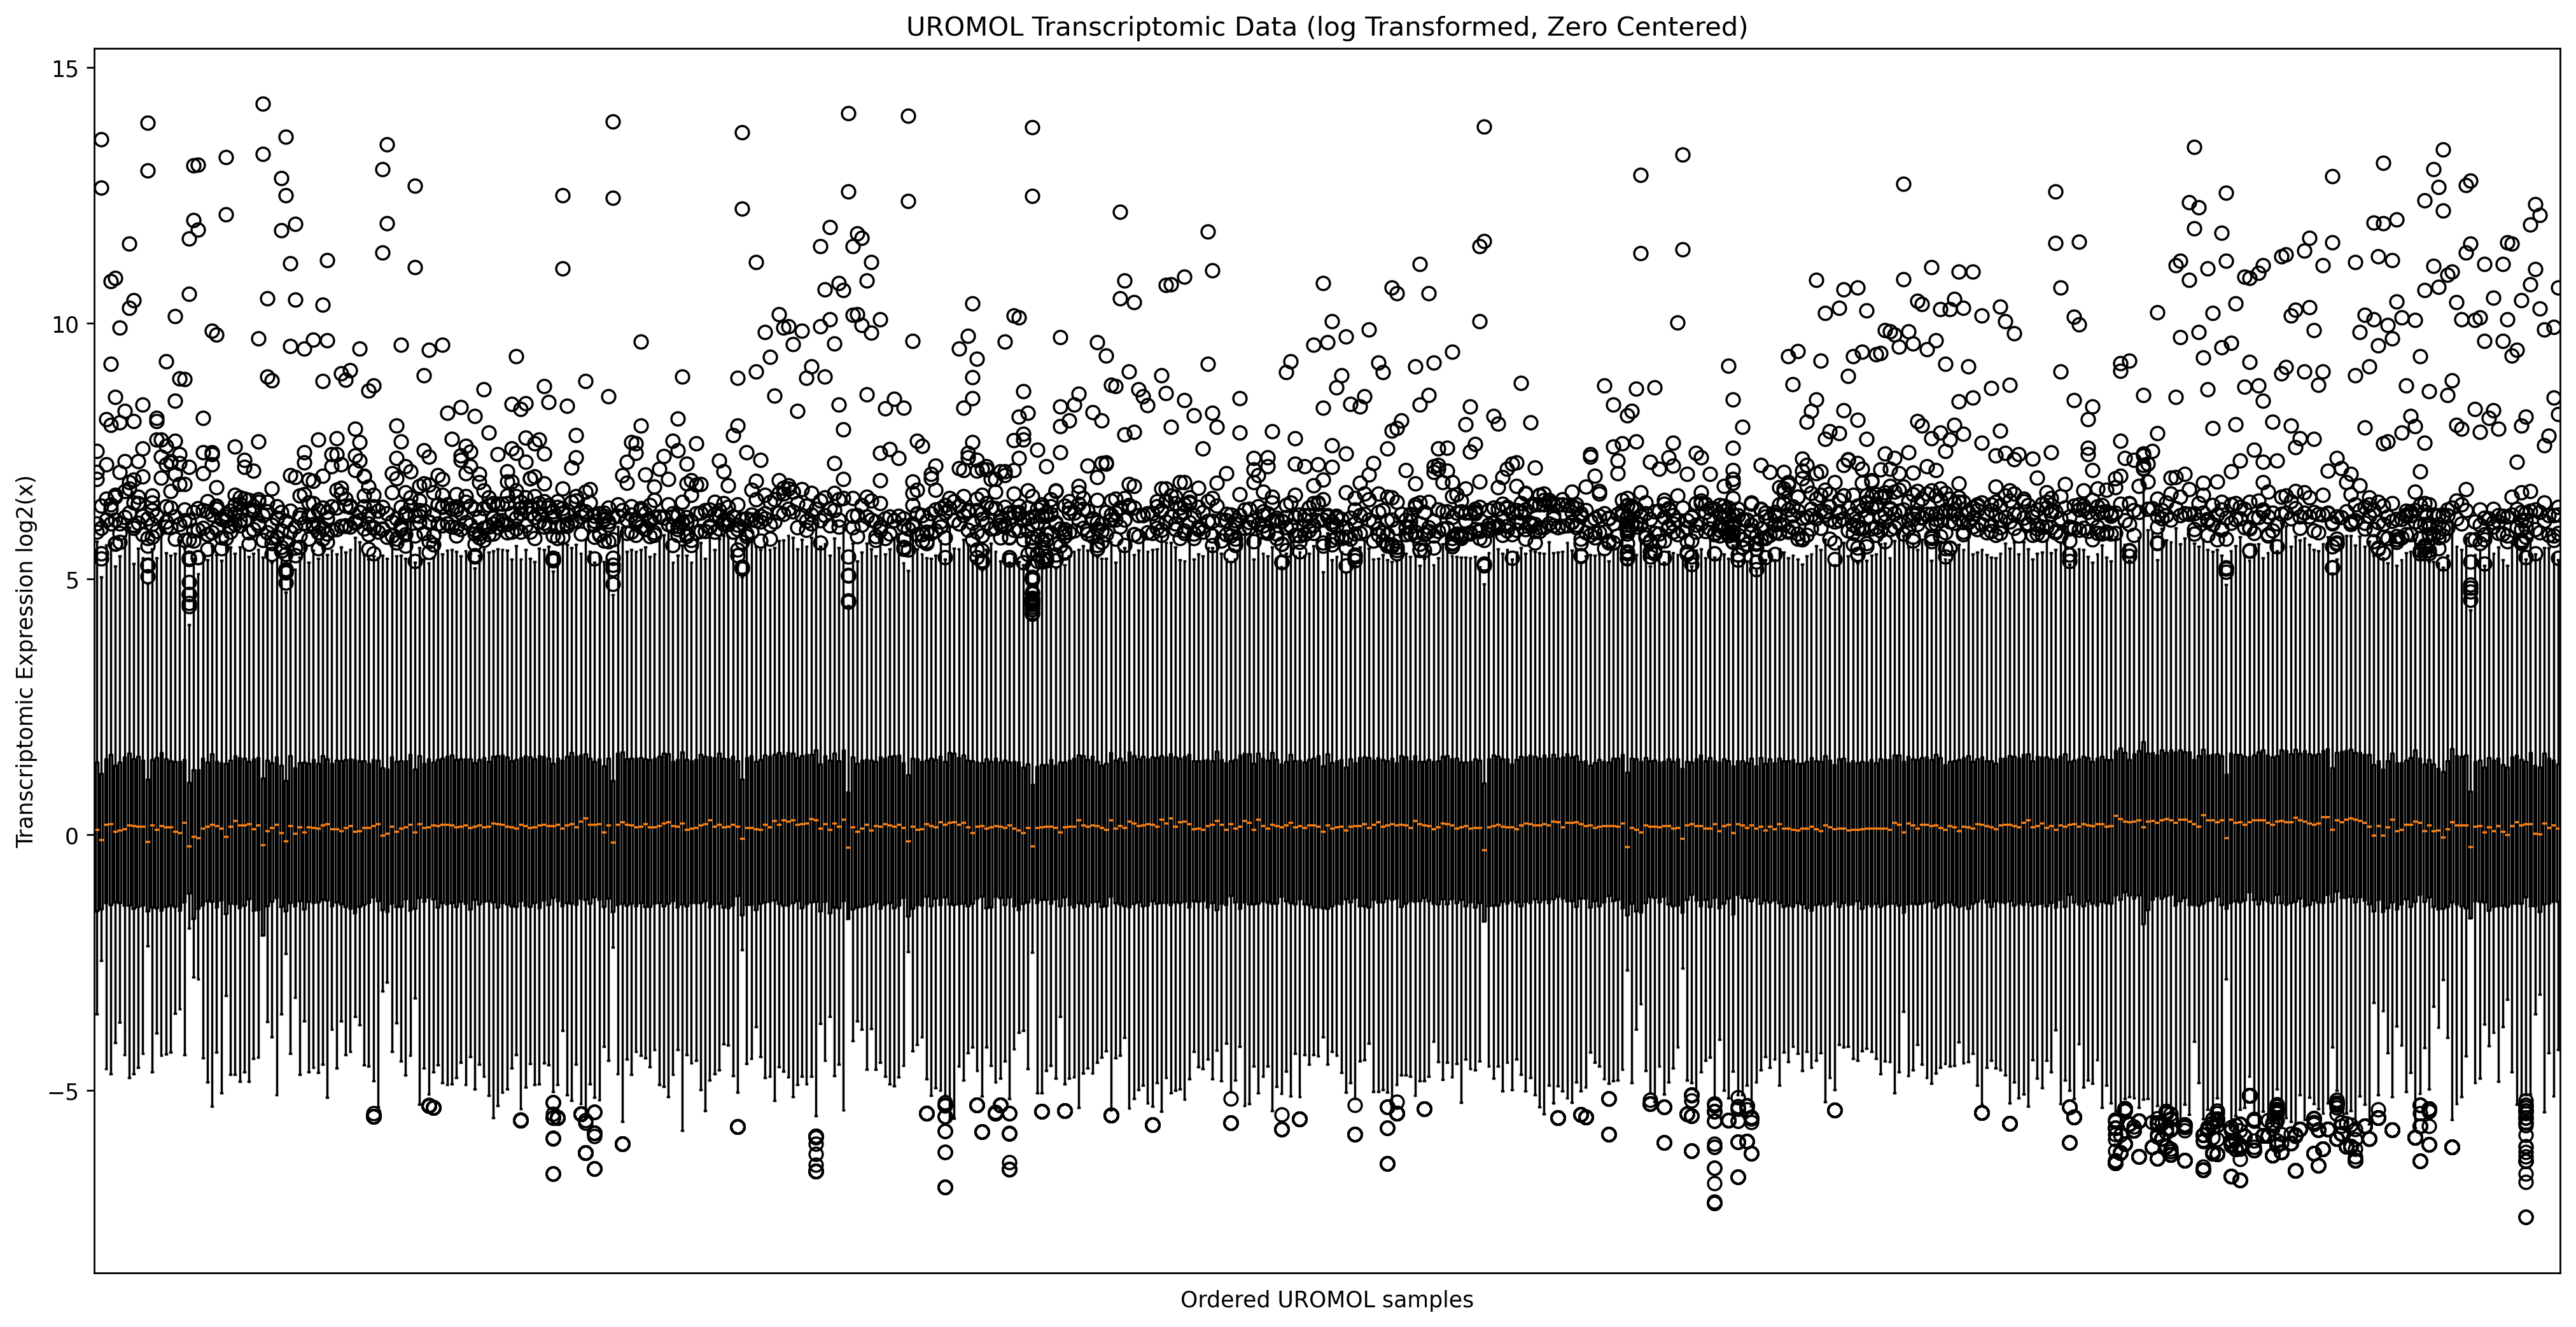

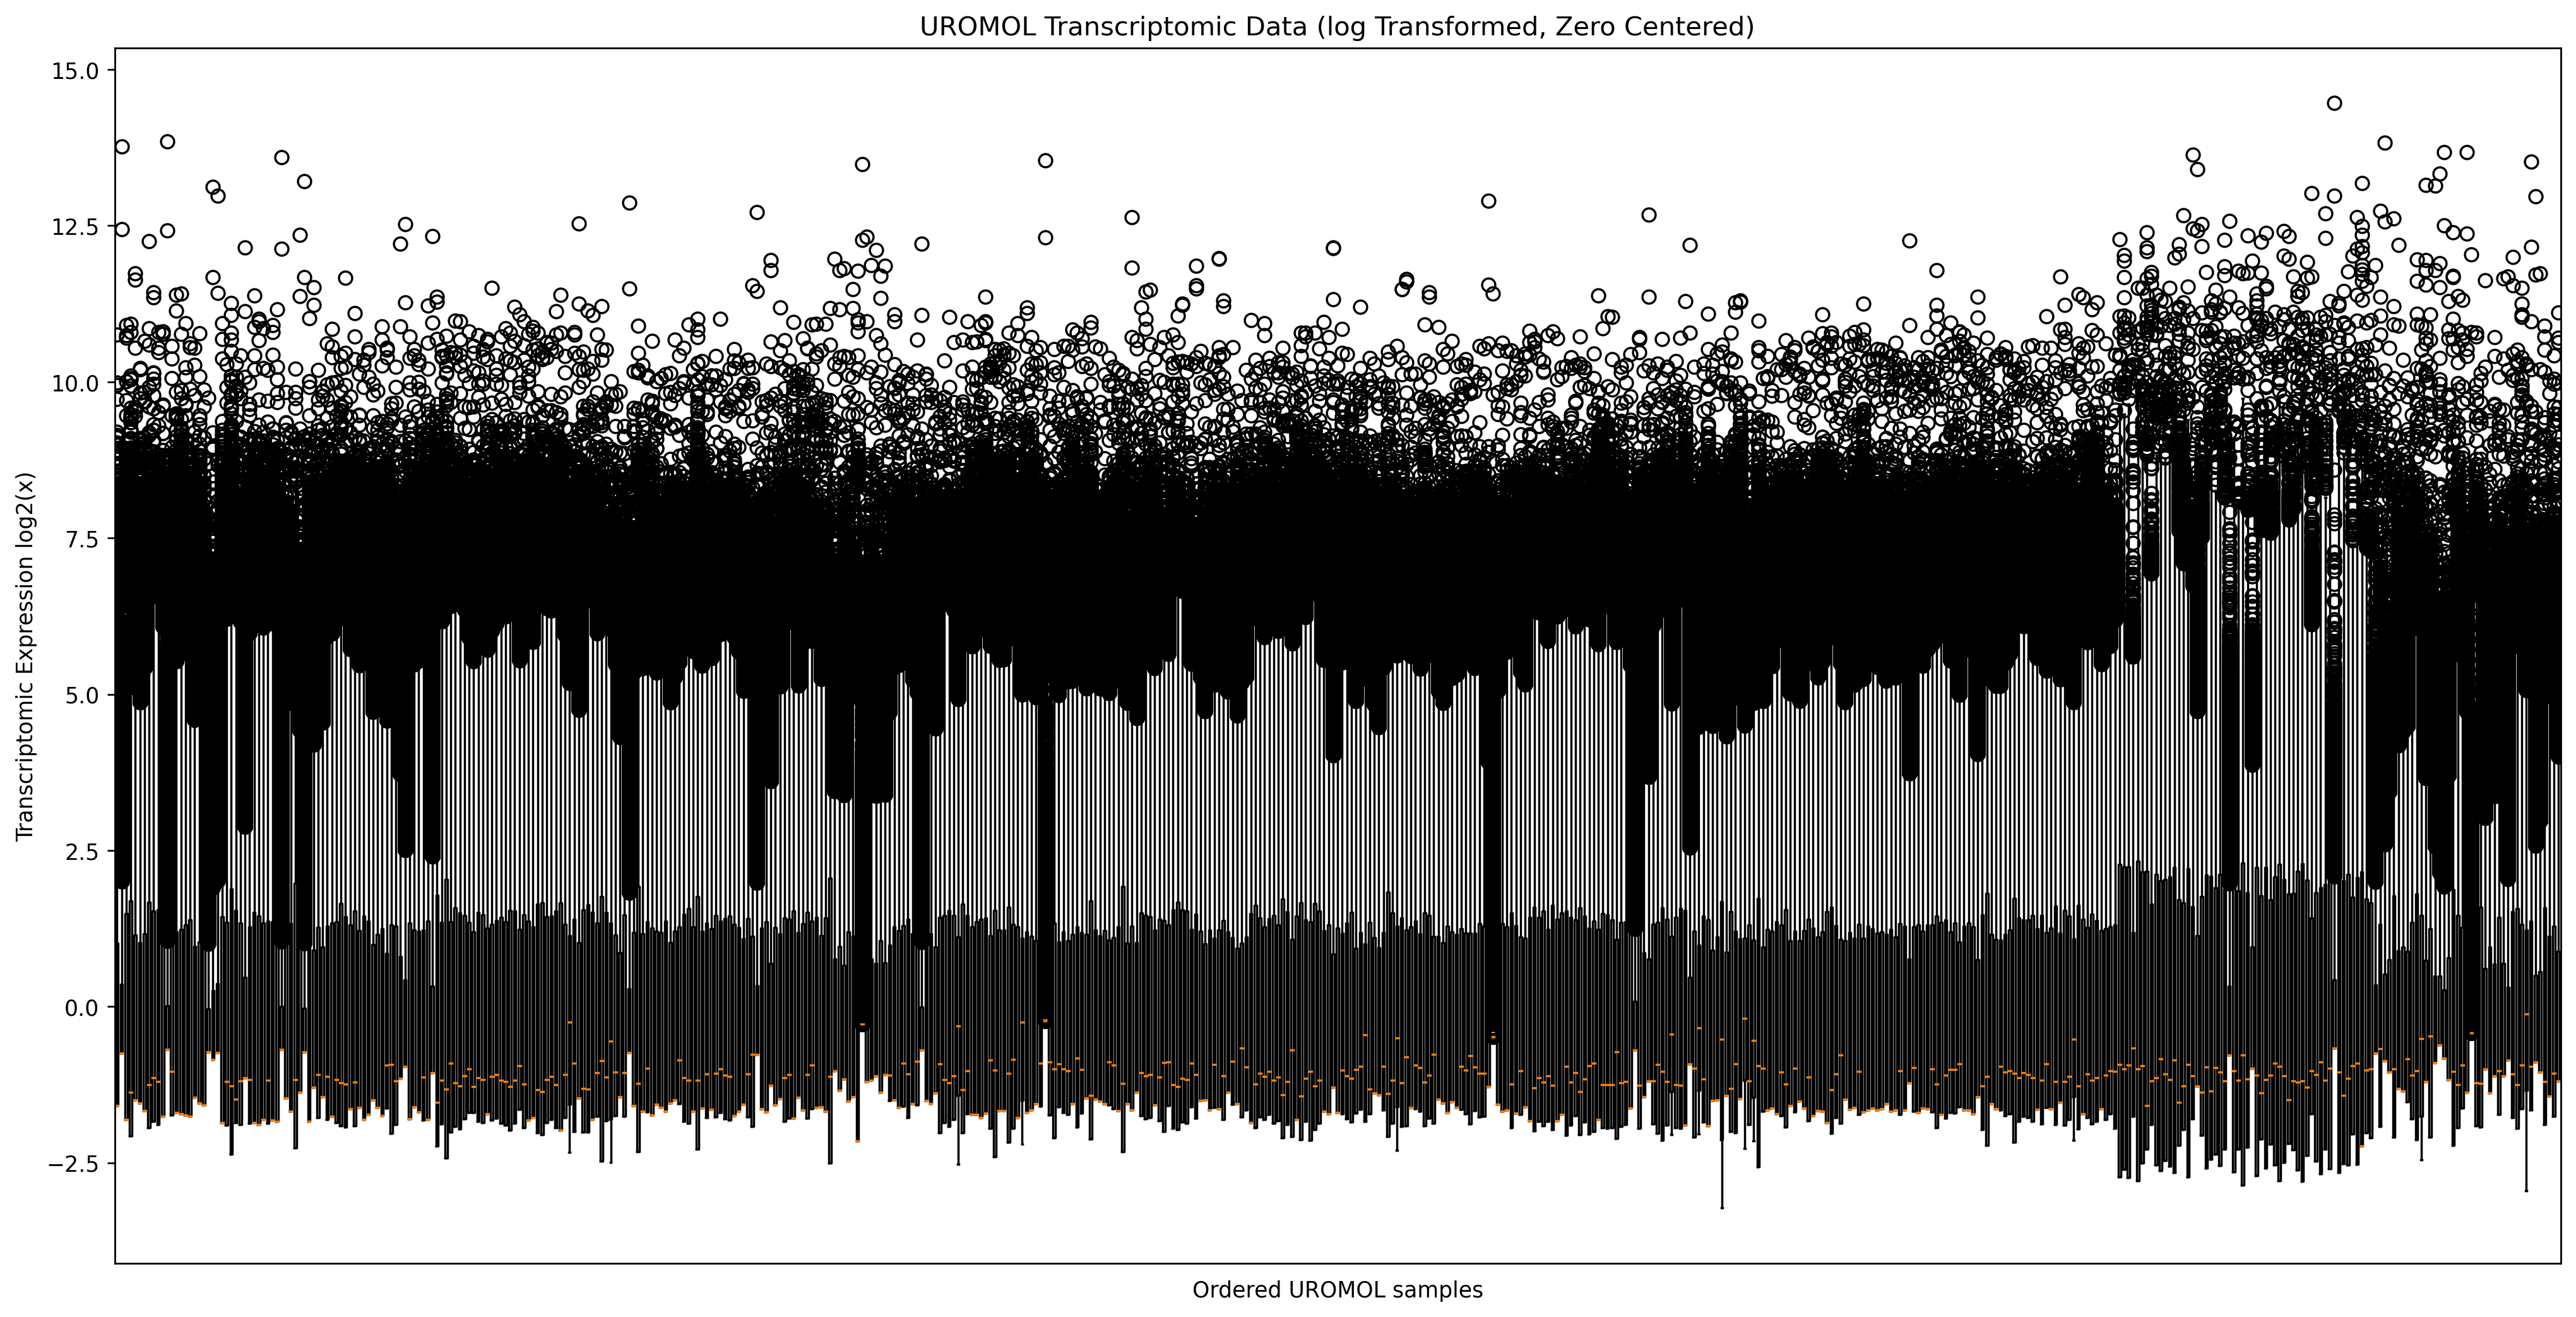

In [2]:
from Funcs.Boxplot import GenerateBoxplot

GenerateBoxplot(TE, 'UROMOL-TEBoxplot.png')
GenerateBoxplot(Gene, 'UROMOL-GeneBoxplot.png')

## DBSCAN Outlier Detection

1. Compute and plot the explained variance ratio of the top 100 principal components
2. Evaluate PCs that explain <95% of the data variance (in my case <95% is explained by PC1, so I will evaluate 2 PCs)
3. Compute optimal epsilon value for DBSCAN (compute nearest neighbours distances and set epsilon as point of inflection
4.

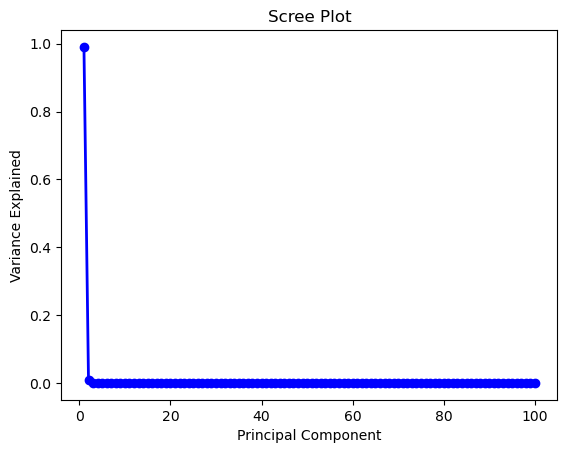

In [3]:
from Funcs.PCAExplainedVarienceRatio import PlotScree

ExplainedVarienceRatio = PlotScree(TE)

In [4]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import numpy as np

tTE = TE.transpose()

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(tTE)
principalDf = pd.DataFrame(data = principalComponents,
                           columns = ['principal component 1',
                                      'principal component 2'],
                           index=tTE.index.values.tolist())
print(principalDf.head())

       principal component 1  principal component 2
U0001          -3.045359e+06           5.135443e+04
U0002           6.769298e+06           2.089651e+06
U0006          -2.755662e+06          -1.092248e+04
U0007           2.366302e+06           1.959183e+05
U0010           2.267029e+04          -1.717183e+05


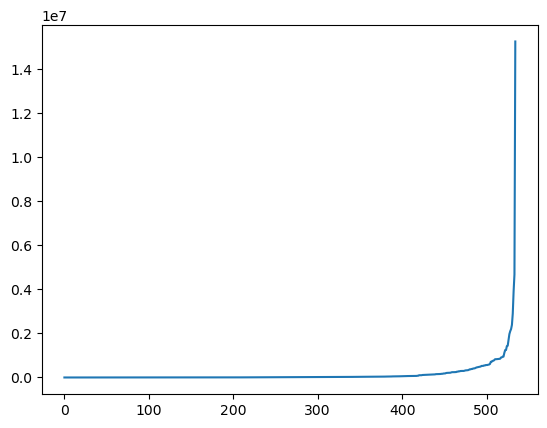

In [5]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(principalDf)
distances, indices = nbrs.kneighbors(principalDf)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

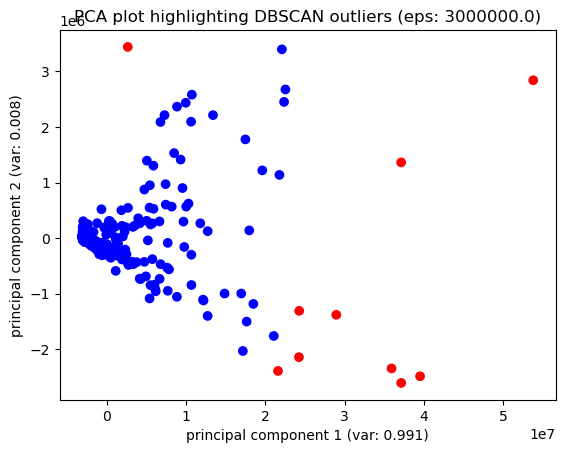

In [6]:
from sklearn.cluster import DBSCAN
epsilon = 0.3 * 1e7
dbscan = DBSCAN(eps = epsilon, min_samples = 5)
tTEoutlier = dbscan.fit(tTE)
clusters = tTEoutlier.labels_

outlier = []
colors = []

for cluster in clusters:
    if cluster < 0:
        colors.append('r')
        outlier.append(1)
    else:
        colors.append('b')
        outlier.append(0)

tTE.loc[:, 'outlier'] = outlier

plt.scatter(principalDf.loc[:,'principal component 1'],
            principalDf.loc[:, 'principal component 2'],
            c=colors)
plt.title(f'PCA plot highlighting DBSCAN outliers (eps: {round(epsilon, 3)})')
plt.xlabel(f'principal component 1 (var: {round(ExplainedVarienceRatio[0], 3)})')
plt.ylabel(f'principal component 2 (var: {round(ExplainedVarienceRatio[1], 3)})')
plt.savefig('PCA-DBSCAN-Outliers.png')
plt.show()

In [8]:
tTE.loc[:, 'outlier'].to_csv('UROMOL-Outliers.csv')